In [5]:
#!pip install -U transformers accelerate torch pillow

In [23]:
#!pip install qwen-vl-utils
#!pip inst|all torchvision
#!pip install ipywidgets
!pip install opencv-python
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------- ----------------------- 16.5/39.0 MB 79.7 MB/s eta 0:00:01
   ------------------------------- -------- 31.2/39.0 MB 76.0 MB/s eta 0:00:01
   ---------------------------------------- 39.0/39.0 MB 75.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   -------------------------------------- - 12.6/12.9 MB 65.9 MB/s eta 0:00:01
   ---------------------------------------- 12.9/12.9 MB 62.3 MB/s eta 0:00:00

  Attempting uninstall: numpy

    Found existing installation: numpy 2.3.2

   ---------------------------------------- 0/2 [numpy]
    Uninstalling numpy-2.3.2:
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
      Successfully uninstalled numpy-2.3.2
   ---------------------------------------- 0/2 [numpy]
   --------------

  You can safely remove it manually.
  You can safely remove it manually.


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 8.1/8.1 MB 83.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 125.0 MB/s eta 0:00:00

   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   -------------------------- ------------- 4/6 [contourpy]
   --------------------------------- ------ 5/6 [matplotlib]
   -----------------------------

In [25]:
from PIL import Image
from transformers import AutoProcessor, Qwen2VLForConditionalGeneration
from qwen_vl_utils import process_vision_info
import torch
import matplotlib.pyplot as plt
import cv2

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
print(device)

cpu


In [4]:
model_id = "Qwen/Qwen2-VL-2B-Instruct"

In [5]:
min_pixels = 256*28*28     # lower bound on processed image area
max_pixels = 1280*28*28    # upper bound on processed image area

In [6]:
processor = AutoProcessor.from_pretrained(
    model_id, 
    min_pixels=min_pixels, 
    max_pixels=max_pixels
)

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


In [16]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id, 
    cache_dir="model_dir",
    torch_dtype="auto",         # bf16/fp16 on GPU, fp32 on CPU
    device_map="cpu"           # place weights on the best available device(s)
).eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
image_path = "Tay.jpg"

In [9]:
question   = "Describe the image"

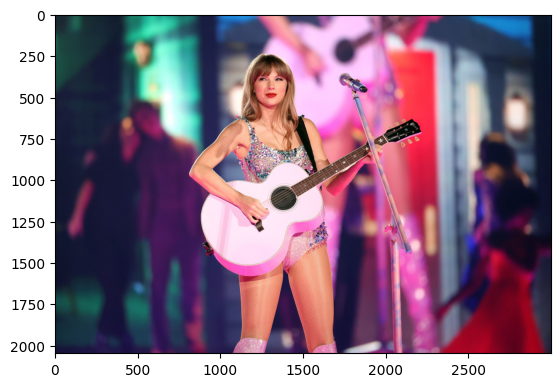

In [28]:
#img = Image.open(image_path).convert("RGB")
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [12]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": img},      # the PIL image object
            {"type": "text",  "text": question},  # your instruction/question
        ],
    }
]

In [13]:
text_prompt = processor.apply_chat_template(
    messages,
    tokenize=False,               # produce a plain string first
    add_generation_prompt=True    # appends the assistant prefix the model expects
)


In [14]:
image_inputs, video_inputs = process_vision_info(messages)

In [17]:
inputs = processor(
    text=[text_prompt],           # list for batch-ability, even if size 1
    images=image_inputs,          # normalized & resized according to min/max pixels
    videos=video_inputs,          # (unused here, but Qwen supports videos)
    padding=True,                 # pad to the longest sequence in the batch
    return_tensors="pt"           # PyTorch tensors
).to(device)

In [18]:
with torch.inference_mode():      # no autograd => less memory, a bit faster
    out_ids = model.generate(
        **inputs,
        max_new_tokens=192        # cap length; lower for tighter VRAM/time
        # tip: add do_sample=True, temperature=0.2 for more diverse answers
    )

In [19]:
prompt_len = inputs["input_ids"].shape[-1]
new_tokens = out_ids[:, prompt_len:]

In [20]:
answer = processor.batch_decode(
    new_tokens,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=True
)[0]

In [21]:
print(answer)

The image shows a person performing on stage. They are holding a pink guitar and wearing a sparkly outfit with fishnet stockings. The background features colorful lighting and other performers.
